In [1]:
!pip install -U git+https://github.com/cseveriano/fts2image

  Cloning https://github.com/cseveriano/fts2image to /tmp/pip-req-build-_g_w4m6o
  Running setup.py bdist_wheel for fts2image ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-oy3df9wp/wheels/22/a1/62/57410665915134ffe4bc11ede1f9a47b1f4b29d8aad9582d31
Successfully built fts2image


In [2]:
!pip install -U git+https://github.com/petroniocandido/pyFTS

  Cloning https://github.com/petroniocandido/pyFTS to /tmp/pip-req-build-jv051_gg
  Running setup.py bdist_wheel for pyFTS ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0wj3doz/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS


In [0]:
import pandas as pd
import numpy as np
import os
from pyFTS.partitioners import Grid
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

from fts2image import MultiChannelFuzzyImageCNN

## Auxiliary Functions

In [0]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm_data, original_data):
    min = original_data.min()

    max = original_data.max()

    return [(n * (max-min)) + min for n in norm_data]

def calculate_rmse(test, forecast, order, step):
    rmse = math.sqrt(mean_squared_error(test.iloc[(order):], forecast[:-step]))
    print("RMSE : "+str(rmse))
    return rmse

def split_data(df, interval):
    sample_df = df.loc[interval]

    week = (sample_df.index.day - 1) // 7 + 1

    # PARA OS TESTES:
    # 2 SEMANAS PARA TREINAMENTO
    train_df = sample_df.loc[week <= 2]

    # 1 SEMANA PARA VALIDACAO
    validation_df = sample_df.loc[week == 3]

    # 1 SEMANA PARA TESTES
    test_df = sample_df.loc[week > 3]

    return (train_df, validation_df, test_df)

## Load Dataset

In [0]:
from urllib import request

dataset_path = "https://github.com/cseveriano/fts2image/raw/master/data/wind/"

request.urlretrieve(dataset_path+"df_wind_total.pkl", "df_wind")

df = pd.read_pickle("df_wind")

In [0]:
channel_1 = 'WTG01_Speed'
channel_2 = 'WTG01_Dir'
output = 'WTG01_Speed'

#Normalize Data

# Perform Normalization
norm_df = normalize(df)

# Split data
interval = ((df.index >= '2017-05') & (df.index <= '2017-06'))

(train_df, validation_df, test_df) = split_data(df, interval)
(norm_train_df, norm_validation_df, norm_test_df) = split_data(norm_df, interval)

## Wind Forecasting

In [0]:
def fuzzy_cnn_forecast(train_df, test_df, _order, _steps):
    _conv_layers = 2
    _dense_layer_neurons = [50, 40, 5]
    _batch_size=100
    _epochs = 150
    _filters = 8
    _kernel_size = 2
    _npartitions = 100
    _pooling_size = 2
    _dropout = 0

    fuzzy_sets = Grid.GridPartitioner(data=train_df[channel_1].values, npart=_npartitions).sets

    model = MultiChannelFuzzyImageCNN.MultiChannelFuzzyImageCNN([channel_1, channel_2],fuzzy_sets, channel_1, nlags=_order, steps=_steps,
                                        conv_layers=_conv_layers, 
                                        dense_layer_neurons=_dense_layer_neurons, filters=_filters,
                                        kernel_size=_kernel_size, pooling_size=_pooling_size, dropout=_dropout)
    model.fit(train_df, batch_size=_batch_size, epochs=_epochs, plot_images=False)

    forecast = model.predict(test_df)

    return forecast

In [8]:
_order = 144
_steps = 1

forecast = fuzzy_cnn_forecast(norm_train_df, norm_test_df,  _order, _steps)
forecast = denormalize(forecast, df[output])

Epoch 1/150
1835/1835 [==============================] - 5s 3ms/step - loss: 0.0071
Epoch 2/150
1835/1835 [==============================] - 1s 704us/step - loss: 0.0027
Epoch 3/150
1835/1835 [==============================] - 1s 701us/step - loss: 0.0016
Epoch 4/150
1835/1835 [==============================] - 1s 731us/step - loss: 0.0012
Epoch 5/150
1835/1835 [==============================] - 1s 731us/step - loss: 7.0410e-04
Epoch 6/150
1835/1835 [==============================] - 1s 739us/step - loss: 6.0347e-04
Epoch 7/150
1835/1835 [==============================] - 1s 734us/step - loss: 5.9094e-04
Epoch 8/150
1835/1835 [==============================] - 1s 738us/step - loss: 4.3860e-04
Epoch 9/150
1835/1835 [==============================] - 1s 720us/step - loss: 3.3554e-04
Epoch 10/150
1835/1835 [==============================] - 1s 725us/step - loss: 2.5241e-04
Epoch 11/150
1835/1835 [==============================] - 1s 716us/step - loss: 2.1661e-04
Epoch 12/150
1835/1835 [==

In [9]:
forecast.append(0) ## para manter o mesmo tamanho dos demais
rmse = calculate_rmse(test_df[output], forecast, _order, _steps)
print("RMSE: ", rmse)

RMSE : 2.1346279704733915
RMSE:  2.1346279704733915


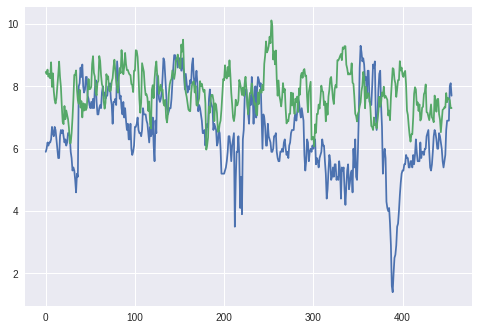

In [10]:
plt.figure()
plt.plot(test_df[output].iloc[_order:600].values)
plt.plot(forecast[:(600-_order)])
plt.show()

## Persistence Forecast

In [0]:
def persistence_forecast(train, test, step):
    predictions = []
    
    for t in np.arange(0,len(test), step):
        yhat = [test.iloc[t]]  * step
        predictions.extend(yhat)
        
    return predictions

In [14]:
step = 1
persistence_order = 1

forecast = persistence_forecast(norm_train_df[output], norm_test_df[output],step)
forecast = denormalize(forecast, df[output])

rmse = calculate_rmse(test_df[output], forecast, persistence_order, step)
print("RMSE: ", rmse)

RMSE : 0.5834671748002891
RMSE:  0.5834671748002891
